<a href="https://colab.research.google.com/github/RandomForestRanger/PhD/blob/master/Feature_Reductions_10_Sep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#installations
!pip install --upgrade -q gspread
!pip install gspread-dataframe
!pip install --upgrade Cython
!pip install --upgrade git+https://github.com/statsmodels/statsmodels
  
#! pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install # see if this works

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import math

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as sklm
from sklearn import preprocessing as pp
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.discrete.discrete_model import NegativeBinomial    #
from statsmodels import discrete
from statsmodels.formula.api import ols


from scipy import stats
import scipy.stats as ss

from patsy import dmatrices

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

%matplotlib inline

In [ ]:
#import data (google drive csv)

#authorise node to access Gdrive via KDL
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

#link to pre-opened csv file in my gdrive 
data1 = gc.open_by_url('https://docs.google.com/spreadsheets/d/12xOwkchQqGupMzfgOYJioRnjeDKKanC2oygUCLgJg44/edit#gid=406608549')

#get the data as a worksheet  
ws = data1.worksheet('RegAll01')

#convert the data to pandas dataframe (can include argument , header = None   if this is needed)
#Woernjaps = get_as_dataframe(ws, usecols=[1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,21,24, 30])
Woernjaps = get_as_dataframe(ws, usecols=[1,2,4,8,10,12,13,14,16,17,19,21,22,49]) 

#since g-sheets brings along a lot of empty/Nan cellumns or rows, this chops them out. Can replace "all" with "any" if I want to discard any incomplete collumns or rows
Woernjaps.dropna(axis=1, how='all' ,inplace=True )
Woernjaps.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
 
Woernjaps.tail()

,Change_in_pop,WAP_not_working,HH_Income_Percent_Poor,Voter_Turnout,Mean_Age,Small_Households,Percentage_Youth,Percentage_NWA,Percentage_White,Percentage_HHWW,Inequality,Percentage_PWM,Percentage_NSL,Percentage_Tribal,Percentage_Male,Percentage_Informal,Percentage_IOT,COGTA_Score,AG_Rating,Pop,Target2
229,0.32,0.36,0.19,0.7246,27.495502,37.044553,32.417989,48.148148,5.961538,31.135380,5.205402,86.665856,0.790241,0.000000,51.579282,39.673050,39.673050,2.0,5.0,56703.0,30.686207
230,0.34,0.34,0.19,0.8302,28.323922,40.339771,37.217716,41.022583,16.033823,16.776172,14.510426,74.061356,2.840637,0.000000,51.445271,4.660040,4.660040,2.0,1.0,75453.0,11.265291
231,-0.07,0.67,0.20,0.7777,25.945665,25.146995,32.072400,53.870005,0.329700,83.246560,4.070981,84.535850,0.793188,90.271695,46.587342,0.000000,97.011744,4.0,2.0,77403.0,11.885844
232,0.02,0.33,0.27,0.7242,28.155124,55.381699,41.283517,32.573745,7.077280,35.074069,9.245362,74.483008,2.882927,0.000000,54.713335,26.959416,26.959416,1.0,2.0,111768.0,41.961921
233,0.30,0.09,0.08,0.6618,29.123616,35.633829,38.070843,37.204067,7.778822,9.157549,14.835113,81.262356,2.405668,0.000000,51.363589,4.954978,4.954978,1.0,2.0,115944.0,14.834748


In [ ]:
Woernjaps.describe()

In [ ]:
# Plot of target
plt.figure(figsize=(9,9))

Woernjaps['Inequality'] = np.log(Woernjaps['Inequality']+1)

sns.scatterplot(x= Woernjaps['Inequality'], y=Woernjaps['NatLog7'], hue= Woernjaps['Inequality'],palette="nipy_spectral", legend='brief', )
#sns.distplot(Woernjaps['Target1'], color="dodgerblue", kde = False )  #
#plt.title('Histogram of protests per municipality')
plt.xlabel('Ineq')
plt.ylabel('Score')

In [ ]:
#Scaling
dataset = Woernjaps
scaler = StandardScaler()
#dataset[['Change_in_pop', 'WAP_not_working','Voter_Turnout','Percentage_Youth','Mean_Age','Percentage_White','Inequality','Percentage_PWM','Percentage_NSL','Percentage_Male','Percentage_Tribal', 'Percentage_Informal','Percentage_IOT']] = scaler.fit_transform(dataset[['Change_in_pop', 'WAP_not_working','Voter_Turnout','Percentage_Youth','Mean_Age','Percentage_White','Inequality','Percentage_PWM','Percentage_NSL','Percentage_Male','Percentage_Tribal', 'Percentage_Informal','Percentage_IOT']]) 
dataset[['Change_in_pop','WAP_not_working','Voter_Turnout','Percentage_Youth','Percentage_White','Inequality','Percentage_PWM','Percentage_NSL','Percentage_Male','Percentage_Informal']] = scaler.fit_transform(dataset[['Change_in_pop','WAP_not_working','Voter_Turnout','Percentage_Youth','Percentage_White','Inequality','Percentage_PWM','Percentage_NSL','Percentage_Male','Percentage_Informal']]) 

# 'Change_in_pop','WAP_not_working','HH_Income_Percent_Poor','Voter_Turnout','Mean_Age','Small_Households','Percentage_Youth','Percentage_NWA','Percentage_White','Percentage_HHWW','Inequality','Percentage_PWM','Percentage_NSL','Percentage_Tribal','Percentage_Male','Percentage_Informal','Percentage_IOT'
# 'Change_in_pop','WAP_not_working','Voter_Turnout','Percentage_Youth', 'Percentage_White','Percentage_PWM','Percentage_NSL','Percentage_Informal'
# 'HH_Income_Percent_Poor', 'Small_Households', 'Percentage_HHWW', 'Mean_Age',  'Percentage_NWA', 'Inequality',  'Percentage_Male', 
#dataset.tail() 

In [ ]:
#place data into new formats, including splitting off the target from the variables (DV from IVs)
observations = len(dataset)
variables = dataset.columns[:-1]
X = dataset.iloc[:, :-1] 
y = dataset['Target2'].values
#dataset.dtypes

#add constant term (for OLS)
Xc = sm.add_constant(X)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [ ]:
Xc.describe().apply(lambda s: s.apply(lambda x: format(round(x,3), 'g')))       

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [ ]:
# Feature extraction
model = LinearRegression()
rfe = RFE(model, 1)
fit = rfe.fit(Xc, y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

In [ ]:
Xc = pd.concat((Xc,pd.get_dummies(Xc['AG_Rating'], prefix= "A", drop_first=True)), axis=1)

Xc.drop(['AG_Rating'], axis=1, inplace=True)
Xc = pd.concat((Xc,pd.get_dummies(Xc['COGTA_Score'], prefix= "C", drop_first=True)), axis=1)
Xc.drop(['COGTA_Score'], axis=1, inplace=True)
#Xc = pd.concat((Xc,pd.get_dummies(Xc['Prov'], prefix="Prov", drop_first=True)), axis=1)
Xc.drop(['Prov'], axis=1, inplace=True)

# dropping unneeded collumns
Xc.drop(columns=['Percentage_PWM','Percentage_Youth','WAP_not_working','Percentage_Informal' ,'C_2.0','C_3.0','C_4.0','A_2.0','A_3.0','A_4.0','A_5.0','Percentage_White' ,'Percentage_NSL'], axis=1, inplace=True)
# 'Voter_Turnout',      'Inequality', 
#Xc.drop(columns=['Pop' ], axis=1, inplace=True)
#'Percentage_Male' , , 'Percentage_HHWW', 'HH_Income_Percent_Poor', ,'Percentage_White',,]
# 'Percentage_NSL',   'Inequality', 
# 'Mean_Age',   'Percentage_Tribal', 'Small_Households','Change_in_pop',  

linear_regression = sm.OLS(y,Xc)
fitted_model = linear_regression.fit()

#Look at model summary
fitted_model.summary()
#fitted_model.conf_int(alpha=0.05, cols=None)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     19.33
Date:                Sat, 23 Nov 2019   Prob (F-statistic):           1.83e-13
Time:                        11:58:55   Log-Likelihood:                -277.94
No. Observations:                 205   AIC:                             565.9
Df Residuals:                     200   BIC:                             582.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.6257      0.066     69.682      0.000       4.495       4.757
Change_in_pop       0.2906      0.094      3.075      0.002       0.104       0.477
Voter_Turnout      -0.0477      0.071     -0.670      0.503      -0.188       0.093
Inequality          0.0534      0.089      0.602      0.548      -0.122       0.228
Percentage_Male     0.3446      0.081      4.237      0.000       0.184       0.505
==============================================================================
Omnibus:                        1.936   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.380   Jarque-Bera (JB):                1.997
Skew:                          -0.227   Prob(JB):                        0.368
Kurtosis:                       2.832   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# The Robust model
rlm_model = sm.RLM(y, Xc, M=sm.robust.norms.HuberT())
fitted_model = rlm_model.fit()

#Look at model summary
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      y   No. Observations:                  234
Model:                            RLM   Df Residuals:                      209
Method:                          IRLS   Df Model:                           24
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 18 Nov 2019                                         
Time:                        10:03:17                                         
No. Iterations:                    29                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     69.7174     24.578      2.837      0.005      21.546     117.889
Change_in_pop              2.6313      0.933      2.822      0.005       0.804       4.459
WAP_not_working            2.4315      1.839      1.322      0.186      -1.173       6.036
HH_Income_Percent_Poor    23.6002     25.338      0.931      0.352     -26.062      73.262
Voter_Turnout             -2.0721      0.757     -2.737      0.006      -3.556      -0.588
Mean_Age                  -1.8764      1.869     -1.004      0.315      -5.540       1.787
Small_Households          -0.1124      0.157     -0.715      0.475      -0.421       0.196
Percentage_Youth          -3.4245      2.179     -1.572      0.116      -7.696       0.846
Percentage_NWA            -1.4260      0.526     -2.713      0.007      -2.456      -0.396
Percentage_White           0.4045      1.491      0.271      0.786      -2.517       3.326
Percentage_HHWW            0.0524      0.063      0.831      0.406      -0.071       0.176
Inequality                -2.4839      1.092     -2.275      0.023      -4.624      -0.344
Percentage_PWM            -2.6494      1.799     -1.473      0.141      -6.175       0.876
Percentage_NSL            -0.2488      0.872     -0.285      0.775      -1.957       1.460
Percentage_Tribal         -0.6670      3.947     -0.169      0.866      -8.404       7.069
Percentage_Male           -1.2586      1.300     -0.968      0.333      -3.806       1.289
Percentage_Informal        1.0683      0.877      1.218      0.223      -0.651       2.788
Percentage_IOT            -4.1624      4.489     -0.927      0.354     -12.960       4.635
A_2.0                      7.6396      3.637      2.101      0.036       0.512      14.768
A_3.0                      7.7751      3.684      2.110      0.035       0.554      14.996
A_4.0                     14.2300      5.421      2.625      0.009       3.605      24.855
A_5.0                     10.3942      3.632      2.862      0.004       3.275      17.513
C_2.0                      1.1868      2.081      0.570      0.569      -2.893       5.266
C_3.0                      4.4930      2.699      1.664      0.096      -0.798       9.784
C_4.0                      2.3618      3.849      0.614      0.540      -5.183       9.906
==========================================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

In [ ]:
Xc = pd.concat((Xc,pd.get_dummies(Xc['AG_Rating'], prefix= "A", drop_first=True)), axis=1)
Xc.drop(['AG_Rating'], axis=1, inplace=True)
Xc = pd.concat((Xc,pd.get_dummies(Xc['COGTA_Score'], prefix="C", drop_first=True)), axis=1)
Xc.drop(['COGTA_Score'], axis=1, inplace=True)
Xc.drop(['Pop'], axis=1, inplace=True)

In [ ]:
#Weighted Least Squares
wls_model = sm.WLS(y,Xc, weights=dataset['Pop'] )
fitted_model = wls_model.fit()

#Look at model summary
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.422
Model:                            WLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     6.370
Date:                Mon, 18 Nov 2019   Prob (F-statistic):           8.08e-15
Time:                        10:07:38   Log-Likelihood:                -932.00
No. Observations:                 234   AIC:                             1914.
Df Residuals:                     209   BIC:                             2000.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    159.8303     33.245      4.808      0.000      94.292     225.369
Change_in_pop              4.6107      1.454      3.172      0.002       1.745       7.476
WAP_not_working            8.2427      2.564      3.215      0.002       3.188      13.297
HH_Income_Percent_Poor   -43.5244     34.657     -1.256      0.211    -111.846      24.798
Voter_Turnout             -1.3408      0.978     -1.371      0.172      -3.269       0.587
Mean_Age                  -5.1748      2.686     -1.927      0.055     -10.470       0.120
Small_Households           0.2195      0.224      0.979      0.329      -0.222       0.662
Percentage_Youth         -11.8399      3.386     -3.497      0.001     -18.514      -5.166
Percentage_NWA            -3.2221      0.717     -4.497      0.000      -4.635      -1.809
Percentage_White           0.5447      1.861      0.293      0.770      -3.124       4.214
Percentage_HHWW           -0.0303      0.084     -0.361      0.719      -0.196       0.135
Inequality                -3.5785      0.800     -4.471      0.000      -5.156      -2.001
Percentage_PWM            -1.5327      2.401     -0.638      0.524      -6.267       3.201
Percentage_NSL             2.4106      1.381      1.746      0.082      -0.312       5.133
Percentage_Tribal         -0.2219      5.295     -0.042      0.967     -10.660      10.216
Percentage_Male           -6.3071      1.847     -3.415      0.001      -9.948      -2.666
Percentage_Informal       -0.1965      1.256     -0.156      0.876      -2.673       2.280
Percentage_IOT             0.6515      6.127      0.106      0.915     -11.428      12.731
A_2.0                     10.6019      6.423      1.651      0.100      -2.060      23.264
A_3.0                      9.8132      6.399      1.534      0.127      -2.802      22.428
A_4.0                     15.0415      7.693      1.955      0.052      -0.125      30.208
A_5.0                     14.1127      6.385      2.210      0.028       1.525      26.701
C_2.0                     -2.4096      2.843     -0.848      0.398      -8.014       3.195
C_3.0                     -2.9943      4.178     -0.717      0.474     -11.230       5.241
C_4.0                     -6.6805      5.615     -1.190      0.235     -17.749       4.388
==============================================================================
Omnibus:                       78.838   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              401.331
Skew:                           1.231   Prob(JB):                     7.11e-88
Kurtosis:                       8.924   Cond. No.                     3.98e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance mat

In [ ]:
#Scaling
dataset = Woernjaps
scaler = StandardScaler()
dataset[['Change_in_pop','WAP_not_working','HH_Income_Percent_Poor','Voter_Turnout','Mean_Age','Small_Households','Percentage_Youth','Percentage_NWA','Percentage_White','Percentage_HHWW','Inequality','Percentage_PWM','Percentage_NSL','Percentage_Tribal','Percentage_Male','Percentage_Informal','Percentage_IOT']] = scaler.fit_transform(dataset[['Change_in_pop','WAP_not_working','HH_Income_Percent_Poor','Voter_Turnout','Mean_Age','Small_Households','Percentage_Youth','Percentage_NWA','Percentage_White','Percentage_HHWW','Inequality','Percentage_PWM','Percentage_NSL','Percentage_Tribal','Percentage_Male','Percentage_Informal','Percentage_IOT']]) 

# The Frequency-Weighted model
import statsmodels.formula.api as smf

f = """ Q('Target2') ~ Q('Change_in_pop') + Q('WAP_not_working') + Q('HH_Income_Percent_Poor') + Q('Voter_Turnout') + Q('Mean_Age')	+ Q('Small_Households') + Q('Percentage_Youth') + Q('Percentage_NWA') + Q('Percentage_White')+ Q('Percentage_HHWW')	+ Q('Inequality')	+ Q('Percentage_PWM') + Q('Percentage_NSL') + Q('Percentage_Tribal') + Q('Percentage_Male')	+ Q('Percentage_Informal') +  Q('Percentage_IOT') + C(AG_Rating) + C(COGTA_Score) """
glm = smf.glm(f, data=dataset, family=sm.families.q(),  freq_weights=np.asarray(dataset['Pop']))
res_f = glm.fit()
print(res_f.summary())
#family=sm.families.GLM()


In [ ]:
# Xc.drop(['const'], axis=1, inplace=True)

print("VIF Scores for each variable: ")
pd.Series([variance_inflation_factor(Xc.values, i) 
               for i in range(Xc.shape[1])], 
              index=Xc.columns)

VIF Scores for each variable: 


Change_in_pop          2.757398
Percentage_White       4.911568
Inequality             4.615493
Percentage_PWM         2.026654
Percentage_Informal    1.610813
dtype: float64

In [ ]:
#Eigenvectors
corr = np.corrcoef(X, rowvar=0)
eigenvalues, eigenvectors = np.linalg.eig(corr)
#check for low eigenvalues (under 0.1)
np.set_printoptions(suppress=True) #to suppress scientific notation
print(np.round(eigenvalues, 2))

[10.19  2.23  1.15  0.97  0.84  0.73  0.69  0.49  0.36  0.29  0.25  0.22
  0.01  0.02  0.05  0.08  0.11  0.16  0.15]


In [ ]:
# Neg Binomial

f = """ Target1 ~  Q('Change_in_pop') + Q('WAP_not_working') + Q('HH_Income_Percent_Poor') + Q('Voter_Turnout') + Q('Mean_Age')	+ Q('Small_Households') + Q('Percentage_Youth') + Q('Percentage_NWA') + Q('Percentage_White')+ Q('Percentage_HHWW')	+ Q('Inequality')	+ Q('Percentage_PWM') + Q('Percentage_NSL') + Q('Percentage_Tribal') + Q('Percentage_Male')	+ Q('Percentage_Informal') +  Q('Percentage_IOT') + C(AG_Rating) + C(COGTA_Score)  """
#    
data =  dataset

response, predictors = dmatrices(f, data, return_type='dataframe')

# Method 1 for Neg Binomial 
nb_results = sm.GLM(response, predictors, family=sm.families.NegativeBinomial()).fit()
print(nb_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Target1   No. Observations:                  234
Model:                            GLM   Df Residuals:                      209
Model Family:        NegativeBinomial   Df Model:                           24
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1448.9
Date:                Mon, 14 Oct 2019   Deviance:                       154.50
Time:                        08:44:48   Pearson chi2:                     186.
No. Iterations:                    15                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [ ]:
# Now doing NB regression using Statsmodels
linear_regression = NegativeBinomial(y, Xc, loglike_method='nb2', offset=None, exposure=None, missing='none')

fitted_model = linear_regression.fit()
fitted_model.summary()

         Current function value: 6.137818
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                      y   No. Observations:                  234
Model:               NegativeBinomial   Df Residuals:                      214
Method:                           MLE   Df Model:                           19
Date:                Mon, 14 Oct 2019   Pseudo R-squ.:                 0.09906
Time:                        08:49:44   Log-Likelihood:                -1436.2
converged:                      False   LL-Null:                       -1594.2
Covariance Type:            nonrobust   LLR p-value:                 1.131e-55
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      5.1109      0.308     16.614      0.000       4.508       5.714
Change_in_pop             -0.0285      0.094     -0.304      0.761      -0.213       0.155
WAP_not_working           -0.0273      0.168     -0.162      0.871      -0.357       0.303
HH_Income_Percent_Poor     0.4389      0.100      4.395      0.000       0.243       0.635
Voter_Turnout             -0.2693      0.066     -4.054      0.000      -0.399      -0.139
Mean_Age                  -0.2208      0.186     -1.189      0.234      -0.585       0.143
Small_Households          -0.3755      0.121     -3.101      0.002      -0.613      -0.138
Percentage_Youth          -0.1179      0.213     -0.555      0.579      -0.535       0.299
Percentage_NWA            -1.1792      0.343     -3.439      0.001      -1.851      -0.507
Percentage_White          -0.1398      0.154     -0.909      0.363      -0.441       0.162
Percentage_HHWW            0.4317      0.162      2.671      0.008       0.115       0.748
Inequality                 0.1003      0.099      1.017      0.309      -0.093       0.294
Percentage_PWM            -0.7347      0.175     -4.191      0.000      -1.078      -0.391
Percentage_NSL             0.0146      0.090      0.163      0.871      -0.161       0.190
Percentage_Tribal          0.3000      0.403      0.744      0.457      -0.490       1.090
Percentage_Male           -0.3926      0.131     -3.000      0.003      -0.649      -0.136
Percentage_Informal        0.1541      0.086      1.795      0.073      -0.014       0.322
Percentage_IOT            -0.3860      0.431     -0.896      0.370      -1.231       0.459
COGTA_Score               -0.1214      0.117     -1.040      0.298      -0.350       0.107
AG_Rating                  0.1150      0.050      2.304      0.021       0.017       0.213
alpha                      0.6118      0.053     11.580      0.000       0.508       0.715
==========================================================================================
"""

In [ ]:
f = """ Target1 ~ Q('Change_in_pop') + Q('WAP_not_working') + Q('HH_Income_Percent_Poor') + Q('Voter_Turnout') + Mean_Age	+ Q('Small_Households') + Q('Percentage_NWA') + Q('Percentage_White')+ Q('Percentage_HHWW')	+ Q('Inequality')	+ Q('Percentage_PWM') + Q('Percentage_NSL') + Q('Percentage_Tribal') + Q('Percentage_Male')	+ Q('Percentage_Informal')  + C(AG_Rating)  """
data = dataset

response, predictors = dmatrices(f, data, return_type='dataframe')

# Method 1 for Neg Binomial 
nb_results = sm.GLM(response, predictors, family=sm.families.NegativeBinomial()).fit()
print(nb_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Target1   No. Observations:                  234
Model:                            GLM   Df Residuals:                      214
Model Family:        NegativeBinomial   Df Model:                           19
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1450.5
Date:                Tue, 03 Sep 2019   Deviance:                       157.78
Time:                        14:28:05   Pearson chi2:                     194.
No. Iterations:                    14                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [ ]:
# Drop superfluous features
Xc.drop(['Large_Households',  'Percentage_Youth', 'Percentage_IOT', 'COGTA_Score', 'Percentage_Poor'], axis=1, inplace=True)
print(Xc.columns[1:])

Index(['Change_in_pop', 'WAP_not_working', 'HH_Income_Percent_Poor',
       'Voter_Turnout', 'Mean_Age', 'Small_Households', 'Percentage_White',
       'Percentage_HHWW', 'Inequality', 'Percentage_PWM', 'Percentage_NSL',
       'Percentage_Male', 'Percentage_Informal', 'AG_Rating'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


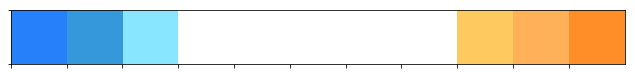

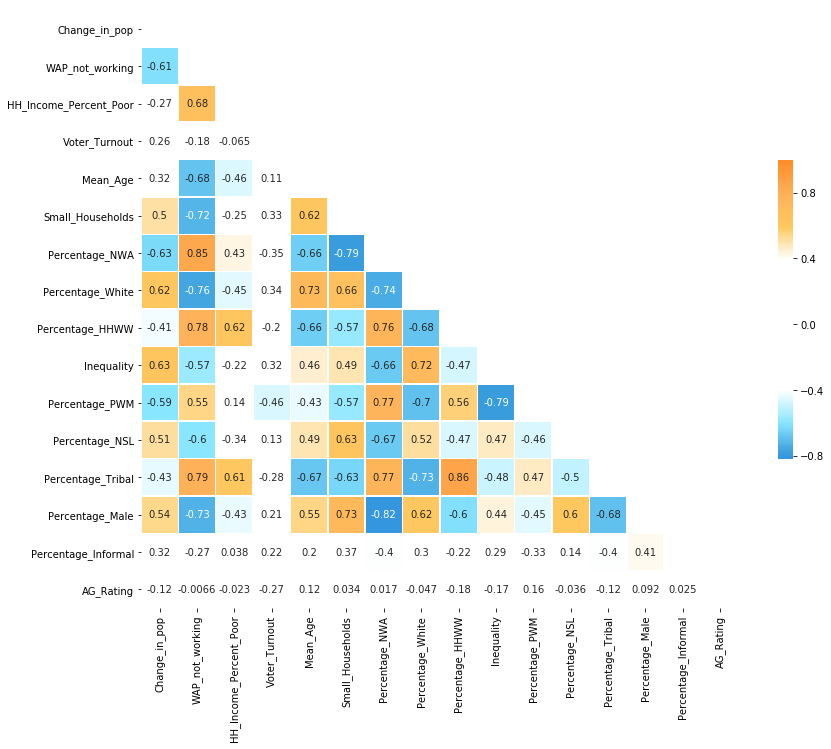

In [ ]:
#Correlation table 

#Temporarily drop constant
Xc.drop('const', axis=1, inplace=True)

hurdle = 0.0
R = np.corrcoef(Xc, rowvar=0) 
R[np.where(np.abs(R)<hurdle)] = 0.0

MJB = ["#2680FA", "#3498db", "#89E6FF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FEC95F", "#FEB159", "#FF8D28"]
sns.set_palette(MJB)
sns.palplot(sns.color_palette())

cmap = LinearSegmentedColormap.from_list('mycmap', MJB)

# Generate a mask for the upper triangle
mask = np.zeros_like(R, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 11))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True, )
#cmap="Spectral"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(R, mask=mask, cmap=cmap, annot=True, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=Xc.columns[:], yticklabels=Xc.columns[:] )

#Add contant back
Xc = sm.add_constant(X)

In [ ]:
Xc.drop(['Percentage_Tribal',  'Percentage_NWA' ], axis=1, inplace=True)

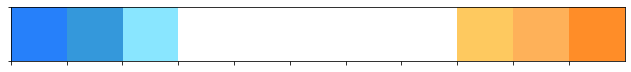

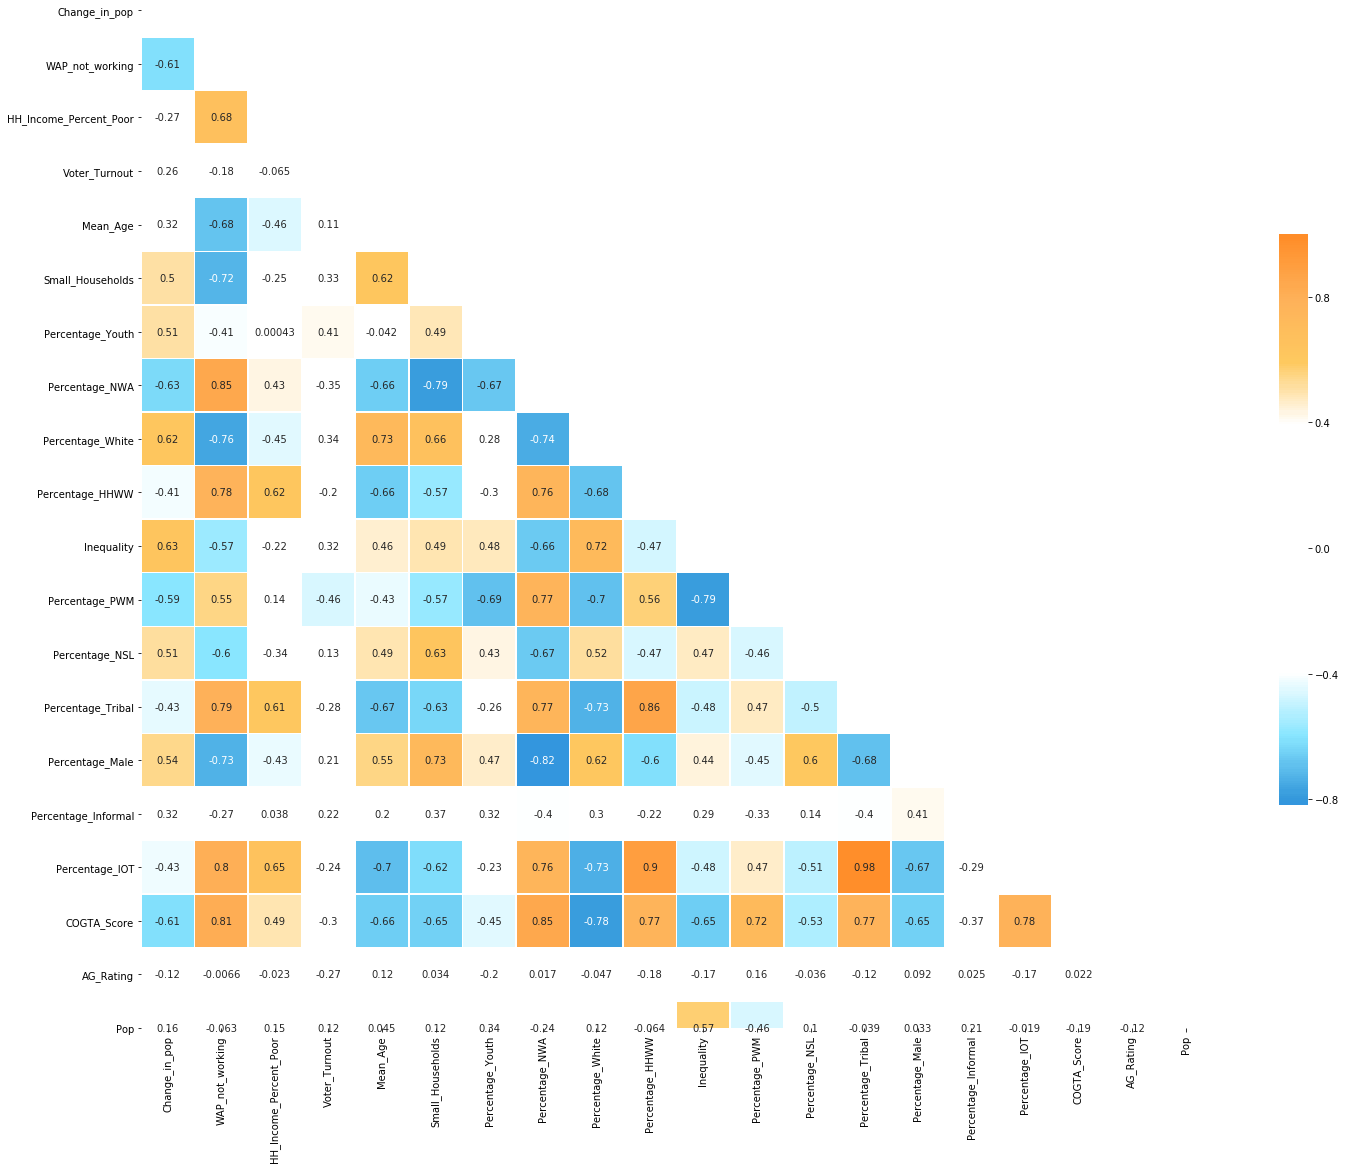

In [ ]:
#Correlation table 

#Temporarily drop constant
#Xc.drop('const', axis=1, inplace=True)

hurdle = 0.0
R = np.corrcoef(X, rowvar=0) 
R[np.where(np.abs(R)<hurdle)] = 0.0

MJB = ["#2680FA", "#3498db", "#89E6FF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FEC95F", "#FEB159", "#FF8D28"]
sns.set_palette(MJB)
sns.palplot(sns.color_palette())

cmap = LinearSegmentedColormap.from_list('mycmap', MJB)

# Generate a mask for the upper triangle
mask = np.zeros_like(R, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(24, 21))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(R, mask=mask, cmap=cmap, annot=True, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=Xc.columns[:], yticklabels=Xc.columns[:] )

#Add contant back
#Xc = sm.add_constant(X)

In [ ]:
f = """ Target1 ~ Q('Change_in_pop') + Q('WAP_not_working') + Q('HH_Income_Percent_Poor') + Q('Voter_Turnout') + Mean_Age	+ Q('Small_Households') + Q('Percentage_White')+ Q('Percentage_HHWW')	+ Q('Inequality')	+ Q('Percentage_PWM') + Q('Percentage_NSL')  + Q('Percentage_Male')	+ Q('Percentage_Informal')  + C(AG_Rating)  """
data = dataset

response, predictors = dmatrices(f, data, return_type='dataframe')

# Method 1 for Neg Binomial 
nb_results = sm.GLM(response, predictors, family=sm.families.NegativeBinomial()).fit()
print(nb_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Target1   No. Observations:                  234
Model:                            GLM   Df Residuals:                      216
Model Family:        NegativeBinomial   Df Model:                           17
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1458.0
Date:                Tue, 03 Sep 2019   Deviance:                       172.80
Time:                        14:30:12   Pearson chi2:                     253.
No. Iterations:                    15                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [ ]:
# Exploratory final negative binomial - do not run cell
data1 = gc.open_by_url('https://docs.google.com/spreadsheets/d/12xOwkchQqGupMzfgOYJioRnjeDKKanC2oygUCLgJg44/edit#gid=406608549')
ws = data1.worksheet('RegAll01')
Woernjaps = get_as_dataframe(ws, usecols=[1, 2, 3, 4, 6, 8, 10, 11, 12, 13, 14, 16, 17, 21, 22]) # 
Woernjaps.dropna(axis=1, how='all' ,inplace=True )
Woernjaps.dropna(axis=0, how='all', thresh=None, subset=None, inplace=True)

dataset = Woernjaps
f = """ Target1 ~ Q('Change_in_pop') + Q('WAP_not_working') + Q('HH_Income_Percent_Poor') + Q('Voter_Turnout')	+ Q('Small_Households') + Q('Percentage_Youth') + Q('Percentage_White')+ Q('Percentage_HHWW')	+ Q('Inequality')	+ Q('Percentage_PWM') + Q('Percentage_NSL')  + Q('Percentage_Male')	+ Q('Percentage_Informal')  + C(AG_Rating)  """
data = dataset

response, predictors = dmatrices(f, data, return_type='dataframe')

nb_results = sm.GLM(response, predictors, family=sm.families.NegativeBinomial()).fit()
print(nb_results.summary())

,Change_in_pop,WAP_not_working,HH_Income_Percent_Poor,Voter_Turnout,Small_Households,Percentage_Youth,Percentage_White,Percentage_HHWW,Inequality,Percentage_PWM,Percentage_NSL,Percentage_Male,Percentage_Informal,AG_Rating,Target1
229,0.32,0.36,0.19,0.7246,37.044553,32.417989,5.961538,31.135380,5.205402,86.665856,0.790241,51.579282,39.673050,5.0,174.0
230,0.34,0.34,0.19,0.8302,40.339771,37.217716,16.033823,16.776172,14.510426,74.061356,2.840637,51.445271,4.660040,1.0,85.0
231,-0.07,0.67,0.20,0.7777,25.146995,32.072400,0.329700,83.246560,4.070981,84.535850,0.793188,46.587342,0.000000,2.0,92.0
232,0.02,0.33,0.27,0.7242,55.381699,41.283517,7.077280,35.074069,9.245362,74.483008,2.882927,54.713335,26.959416,2.0,469.0
233,0.30,0.09,0.08,0.6618,35.633829,38.070843,7.778822,9.157549,14.835113,81.262356,2.405668,51.363589,4.954978,2.0,172.0


In [ ]:
#What time is it? It's OLS time. 

logy = np.log(y)

linear_regression = sm.OLS(logy,Xc)
fitted_model = linear_regression.fit()

#Look at model summary
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     21.93
Date:                Tue, 03 Sep 2019   Prob (F-statistic):           2.55e-34
Time:                        14:32:27   Log-Likelihood:                -301.86
No. Observations:                 234   AIC:                             633.7
Df Residuals:                     219   BIC:                             685.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      4.4202      0.174     25.369      0.000       4.077       4.764
Change_in_pop             -0.0441      0.093     -0.472      0.637      -0.228       0.140
WAP_not_working           -0.4568      0.161     -2.844      0.005      -0.773      -0.140
HH_Income_Percent_Poor     0.4593      0.107      4.273      0.000       0.247       0.671
Voter_Turnout             -0.2922      0.075     -3.907      0.000      -0.440      -0.145
Mean_Age                   0.0145      0.104      0.139      0.889      -0.191       0.220
Small_Households          -0.3742      0.122     -3.076      0.002      -0.614      -0.134
Percentage_White          -0.2810      0.133     -2.116      0.035      -0.543      -0.019
Percentage_HHWW            0.1280      0.119      1.076      0.283      -0.106       0.362
Inequality                -0.0179      0.111     -0.161      0.872      -0.236       0.200
Percentage_PWM            -1.2439      0.125     -9.919      0.000      -1.491      -0.997
Percentage_NSL             0.0934      0.087      1.072      0.285      -0.078       0.265
Percentage_Male           -0.0535      0.105     -0.508      0.612      -0.261       0.154
Percentage_Informal        0.1586      0.071      2.240      0.026       0.019       0.298
AG_Rating                  0.1301      0.049      2.640      0.009       0.033       0.227
==============================================================================
Omnibus:                        5.316   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                7.001
Skew:                          -0.119   Prob(JB):                       0.0302
Kurtosis:                       3.813   Cond. No.                         12.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# 
data1 = gc.open_by_url('https://docs.google.com/spreadsheets/d/12xOwkchQqGupMzfgOYJioRnjeDKKanC2oygUCLgJg44/edit#gid=406608549')
ws = data1.worksheet('RegAll01')
Woernjaps = get_as_dataframe(ws, usecols=[1, 2, 3, 4, 5, 6,  10, 11, 12, 13, 14, 16, 17, 21, 27]) # 
Woernjaps.dropna(axis=1, how='all' ,inplace=True )
Woernjaps.dropna(axis=0, how='all', thresh=None, subset=None, inplace=True)
Woernjaps.tail()

,Change_in_pop,WAP_not_working,HH_Income_Percent_Poor,Voter_Turnout,Mean_Age,Small_Households,Percentage_White,Percentage_HHWW,Inequality,Percentage_PWM,Percentage_NSL,Percentage_Male,Percentage_Informal,AG_Rating,Target2
229,0.32,0.36,0.19,0.7246,27.495502,37.044553,5.961538,31.135380,5.205402,86.665856,0.790241,51.579282,39.673050,5.0,30.686207
230,0.34,0.34,0.19,0.8302,28.323922,40.339771,16.033823,16.776172,14.510426,74.061356,2.840637,51.445271,4.660040,1.0,11.265291
231,-0.07,0.67,0.20,0.7777,25.945665,25.146995,0.329700,83.246560,4.070981,84.535850,0.793188,46.587342,0.000000,2.0,11.885844
232,0.02,0.33,0.27,0.7242,28.155124,55.381699,7.077280,35.074069,9.245362,74.483008,2.882927,54.713335,26.959416,2.0,41.961921
233,0.30,0.09,0.08,0.6618,29.123616,35.633829,7.778822,9.157549,14.835113,81.262356,2.405668,51.363589,4.954978,2.0,14.834748


In [ ]:
#Scaling
dataset = Woernjaps
scaler = StandardScaler()
dataset[['Change_in_pop', 'WAP_not_working', 'HH_Income_Percent_Poor', 'Voter_Turnout', 'Mean_Age' , 'Small_Households',  'Percentage_White', 'Percentage_HHWW','Inequality','Percentage_PWM', 'Percentage_NSL', 	'Percentage_Male', 'Percentage_Informal']] = scaler.fit_transform(dataset[['Change_in_pop', 'WAP_not_working', 'HH_Income_Percent_Poor', 'Voter_Turnout', 'Mean_Age' , 'Small_Households', 'Percentage_White', 'Percentage_HHWW','Inequality','Percentage_PWM', 'Percentage_NSL',	'Percentage_Male', 'Percentage_Informal']]) 
# removed 'Log(PopSize)' from above
dataset.tail()

,Change_in_pop,WAP_not_working,HH_Income_Percent_Poor,Voter_Turnout,Mean_Age,Small_Households,Percentage_White,Percentage_HHWW,Inequality,Percentage_PWM,Percentage_NSL,Percentage_Male,Percentage_Informal,AG_Rating,Target2
229,1.258081,-0.357200,0.206926,-0.766396,-0.112416,-0.023175,-0.166506,-0.066856,-0.606806,1.099063,-0.943279,1.366845,7.160743,5.0,30.686207
230,1.379430,-0.495700,0.206926,1.558935,0.236041,0.402763,1.365827,-0.592777,0.119152,-0.583656,0.072208,1.307731,0.271921,1.0,11.265291
231,-1.108211,1.789549,0.445451,0.402875,-0.764321,-1.561044,-1.023298,1.841769,-0.695311,0.814704,-0.941820,-0.835153,-0.644943,2.0,11.885844
232,-0.562144,-0.564950,2.115127,-0.775204,0.165040,2.347071,0.003235,0.077402,-0.291617,-0.527365,0.093152,2.749309,4.659331,2.0,41.961921
233,1.136733,-2.226949,-2.416851,-2.149264,0.572415,-0.205524,0.109963,-0.871817,0.144483,0.377688,-0.143217,1.271700,0.329951,2.0,14.834748


In [ ]:
#place data into new formats, including splitting off the target from the variables (DV from IVs)

observations = len(dataset)
variables = dataset.columns[:-1]
X = dataset.iloc[:, :-1] #replaced with .ix with .iloc
y = dataset['Target2'].values
#dataset.dtypes

#add constant term (for OLS)
Xc = sm.add_constant(X)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [ ]:
Xc = pd.concat((Xc,pd.get_dummies(Xc['AG_Rating'], drop_first=True)), axis=1)
Xc.drop(['AG_Rating'], axis=1, inplace=True)

In [ ]:
#Fit model for a quick look (using OLS for now)
linear_regression = sm.OLS(y,Xc)
fitted_model = linear_regression.fit()

#Look at model summary
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     5.804
Date:                Tue, 03 Sep 2019   Prob (F-statistic):           7.48e-11
Time:                        19:09:09   Log-Likelihood:                -885.43
No. Observations:                 234   AIC:                             1807.
Df Residuals:                     216   BIC:                             1869.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     10.6053      4.344      2.441      0.015       2.043      19.167
Change_in_pop              2.5472      1.164      2.188      0.030       0.253       4.842
WAP_not_working           -0.0751      1.980     -0.038      0.970      -3.978       3.828
HH_Income_Percent_Poor     1.6814      1.315      1.279      0.202      -0.910       4.273
Voter_Turnout             -1.0980      0.912     -1.204      0.230      -2.896       0.700
Mean_Age                   1.8685      1.277      1.463      0.145      -0.649       4.386
Small_Households          -1.2256      1.488     -0.823      0.411      -4.159       1.708
Percentage_White           0.7327      1.623      0.451      0.652      -2.466       3.931
Percentage_HHWW           -3.7857      1.453     -2.605      0.010      -6.650      -0.922
Inequality                -2.5105      1.358     -1.848      0.066      -5.187       0.166
Percentage_PWM            -2.0830      1.532     -1.360      0.175      -5.103       0.937
Percentage_NSL             0.0848      1.076      0.079      0.937      -2.036       2.206
Percentage_Male            1.0935      1.307      0.837      0.404      -1.482       3.669
Percentage_Informal        1.3493      0.874      1.544      0.124      -0.373       3.072
2.0                        5.5819      4.501      1.240      0.216      -3.289      14.452
3.0                        5.8049      4.643      1.250      0.213      -3.347      14.957
4.0                        8.3474      6.760      1.235      0.218      -4.977      21.671
5.0                        8.0879      4.582      1.765      0.079      -0.943      17.119
==============================================================================
Omnibus:                       70.247   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.380
Skew:                           1.423   Prob(JB):                     6.69e-35
Kurtosis:                       5.835   Cond. No.                         36.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#Labour / Cap
data1 = gc.open_by_url('https://docs.google.com/spreadsheets/d/12xOwkchQqGupMzfgOYJioRnjeDKKanC2oygUCLgJg44/edit#gid=406608549')
ws = data1.worksheet('RegAll01')
Woernjaps = get_as_dataframe(ws, usecols=[1, 2, 3, 4, 5, 6,  10, 11, 12, 13, 14, 16, 17, 21, 40]) # 
Woernjaps.dropna(axis=1, how='all' ,inplace=True )
Woernjaps.dropna(axis=0, how='all', thresh=None, subset=None, inplace=True)
Woernjaps.tail()


,Change_in_pop,WAP_not_working,HH_Income_Percent_Poor,Voter_Turnout,Mean_Age,Small_Households,Percentage_White,Percentage_HHWW,Inequality,Percentage_PWM,Percentage_NSL,Percentage_Male,Percentage_Informal,AG_Rating,Target15
229,0.32,0.36,0.19,0.7246,27.495502,37.044553,5.961538,31.135380,5.205402,86.665856,0.790241,51.579282,39.673050,5.0,2.292648
230,0.34,0.34,0.19,0.8302,28.323922,40.339771,16.033823,16.776172,14.510426,74.061356,2.840637,51.445271,4.660040,1.0,1.060263
231,-0.07,0.67,0.20,0.7777,25.945665,25.146995,0.329700,83.246560,4.070981,84.535850,0.793188,46.587342,0.000000,2.0,0.129194
232,0.02,0.33,0.27,0.7242,28.155124,55.381699,7.077280,35.074069,9.245362,74.483008,2.882927,54.713335,26.959416,2.0,13.957483
233,0.30,0.09,0.08,0.6618,29.123616,35.633829,7.778822,9.157549,14.835113,81.262356,2.405668,51.363589,4.954978,2.0,1.034982


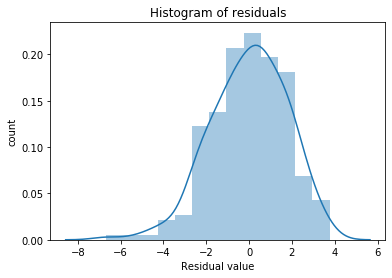

In [ ]:
from sklearn import linear_model
lm = LinearRegression()
lm.fit(Xc,y)
y_score = lm.predict(Xc)

def hist_resids(y, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
hist_resids(y, y_score)

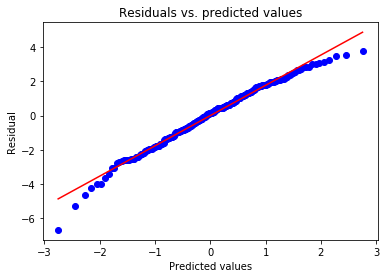

In [ ]:
def resid_qq(y, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    
resid_qq(y, y_score)

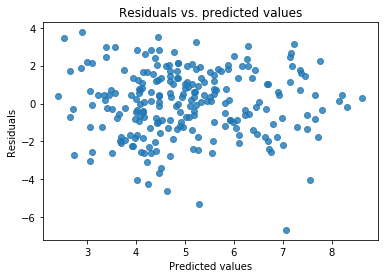

In [ ]:
def resid_plot(y, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False )
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')

resid_plot(y, y_score)

In [ ]:
#Towards the two heterokedastic tests
#Step1
# copied for article at  https://medium.com/@remycanario17/tests-for-heteroskedasticity-in-python-208a0fdb04ab
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
#Step2
f = """Q('2NatLog') ~ Q('Change_in_pop')+Q('WAP_not_working')+Q('Percentage_White')+Q('Voter_Turnout')+Q('Percentage_Youth')+ Q('Inequality')+Q('Percentage_PWM')+Q('Percentage_NSL')+Q('Percentage_Informal')+C(COGTA_Score)+C(AG_Rating)"""

model = ols(formula=f, data=dataset).fit()

In [ ]:
#Step3
white_test = het_white(model.resid,  model.model.exog)

In [ ]:
#Step4
bp_test = het_breuschpagan(model.resid, dataset[['Change_in_pop','WAP_not_working','Voter_Turnout','Percentage_Youth','Percentage_White','Percentage_PWM','Percentage_NSL','Percentage_Informal'] ])

In [ ]:
#Step5
labels = ["LM_Statistic", "LM-Test_p-value", "F-Statistic", "F-Test_p-value"]
print(dict(zip(labels, bp_test)))
print(dict(zip(labels, white_test)))

{'LM_Statistic': 12.087567182517427, 'LM-Test_p-value': 0.09771569975393998, 'F-Statistic': 1.538777113885147, 'F-Test_p-value': 0.14487307562499113}
{'LM_Statistic': 83.89584195489125, 'LM-Test_p-value': 0.9966247717977315, 'F-Statistic': 0.5085233064582946, 'F-Test_p-value': 0.9998558969245661}
